In [1]:
%run "RBM.ipynb"

class Classification_Generation(RBM):
    # n_k is the number of classes
    def __init__(self, n_x, n_k, n_h, W=None, b=None, c=None, k=1, learning=0.1):
        super().__init__(n_x+n_k, n_h, W=None, b=None, c=None, k=1, learning=0.1)
        self.n_x = n_x
        self.n_k = n_k
        return
        
    def convert_input(self, X, Label):
        Label = Label.flatten()
        n_sample = len(Label)
        assert X.shape == (n_sample, self.n_x)
        #attach label to data
        Y = np.zeros(shape=(n_sample, self.n_k))
        Index = np.arange(n_sample)
        Y[Index, Label] = 1
        V = np.append(X, Y, axis=1)
        assert V.shape == (n_sample, self.n_v)
        
        return V
    
    def classify(self, x):
        y = np.arange(self.n_k)
        v = np.append(x, y)
        
        vp, vs = self.reconstruct(v)
        y = vs[-n_k:]
        label = np.argmax(y)
        return label
    
    def generate(self, label, k_cd, init_w, w):
        # this is a very simple generation algorithm with single-layer RBM
        n_x = self.n_x
        n_k = self.n_k
        classes = np.zeros(n_k)
        classes[label] = init_w
        np.random.seed(1234)
    #    v = np.append( np.random.binomial(1, 0.5, n_x), classes)
    #    v = np.append( np.zeros(n_x), classes)
        v = np.append( np.random.uniform(0, 0.8, n_x), classes)
        vp = v.reshape(1,-1)

        classes[label] = w
        for i in range(k_cd):
            vp, vs = self.reconstruct(vp)
            vp[0, -n_k:] = classes

        return vp.flatten()[:-n_k]
            

In [2]:
%run "mnist.ipynb"
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Grid

class MNIST_RBM:
    def __init__(self, folder="../convolution-network"):
        self.train_input = MnistInput("train", folder)
        self.test_input = MnistInput("test", folder)
        self.rbm = None

    def train(self, train_size=-1, n_epoch=50, batch_size=10, learning=0.01):
        d = 28
        n_x = d*d; n_k = 10; n_h = d*10+1
        self.rbm = Classification_Generation(n_x, n_k, n_h, learning)
        n_ep = 0
        n_x = 0 
        X = []
        Y = []
        batch_size = batch_size if batch_size > 0 else 100
        n_epoch = n_epoch if n_epoch > 0 else 1
        for i in range(n_epoch):
            for x, y in self.train_input.read(train_size):
                n_x += 1
                X.append(x)
                Y.append(y)
                if n_x >= batch_size:
                    X = np.array(X).reshape(batch_size, -1) > 30
                    X = X * 1 # make bool into number
                    V = self.rbm.convert_input(X, np.array(Y))
                    self.rbm.contrastive_divergence(V)
                    n_x = 0
                    X = []
                    Y = []                

        return

    def classify(self, test_size=-1, output_size=50):
        d = 28
        n_x = self.rbm.n_x
        n_k = self.rbm.n_k
        n_total=0; n_correct = 0; n_output = 0
        X=[]; Y=[]; Recon=[]; Preds=[]
        for x, y in self.test_input.read(test_size):
            n_total += 1
            v = np.append(np.array(x), np.zeros(n_k))
            vp, vs = self.rbm.reconstruct(v.reshape(1,-1)/255)
            pred = np.argmax(vp.flatten()[-n_k:])
            if y == pred: n_correct += 1 
            if n_output < output_size:
                Preds.append(pred)
                Recon.append(vp.flatten()[:-n_k])
                X.append(x)
                Y.append(y)
                n_output += 1


        accuracy = n_correct/n_total
        print("Accuracy: {}".format(accuracy))

        # output
        ncols = 10
        nrows = int(output_size/5)
        fig = plt.figure(figsize=(ncols, int(nrows*2)), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows,ncols))

        for i, ax in enumerate(grid):
            j = i//2
            if i%2 == 0:
                ax.imshow(X[j].reshape(d,d), cmap=mpl.cm.Greys)
                ax.set_title("Orig: {}".format(Y[j]), y=0)
            else:
                ax.imshow(Recon[j].reshape(d,d), cmap=mpl.cm.Greys)
                ax.set_title("Reco: {}".format(Preds[j]), y=0)

            ax.set_axis_off()

        fig.suptitle('Original and reconstructed digits side by side')
        fig.tight_layout()
        fig.subplots_adjust(top=0.98)    
        plt.show()        
        return

    def generate(self, n_reco=400, init_w=40, w=1):
        digits = []
        for i in range( self.rbm.n_k ):
            digit = self.rbm.generate(i, n_reco, init_w, w)
            digits.append(digit)
        
        # output
        d = 28
        ncols = 10
        nrows = 1
        fig = plt.figure(figsize=(ncols, int(nrows*2)), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows,ncols))

        for i, ax in enumerate(grid):
            ax.imshow(digits[i].reshape(d,d), cmap=mpl.cm.Greys)
            ax.set_title(i)
            ax.set_axis_off()

        fig.suptitle('Generated digit images from numbers')
        fig.tight_layout()
        fig.subplots_adjust(top=0.7)    
        plt.show()        
        return



Accuracy: 0.9182


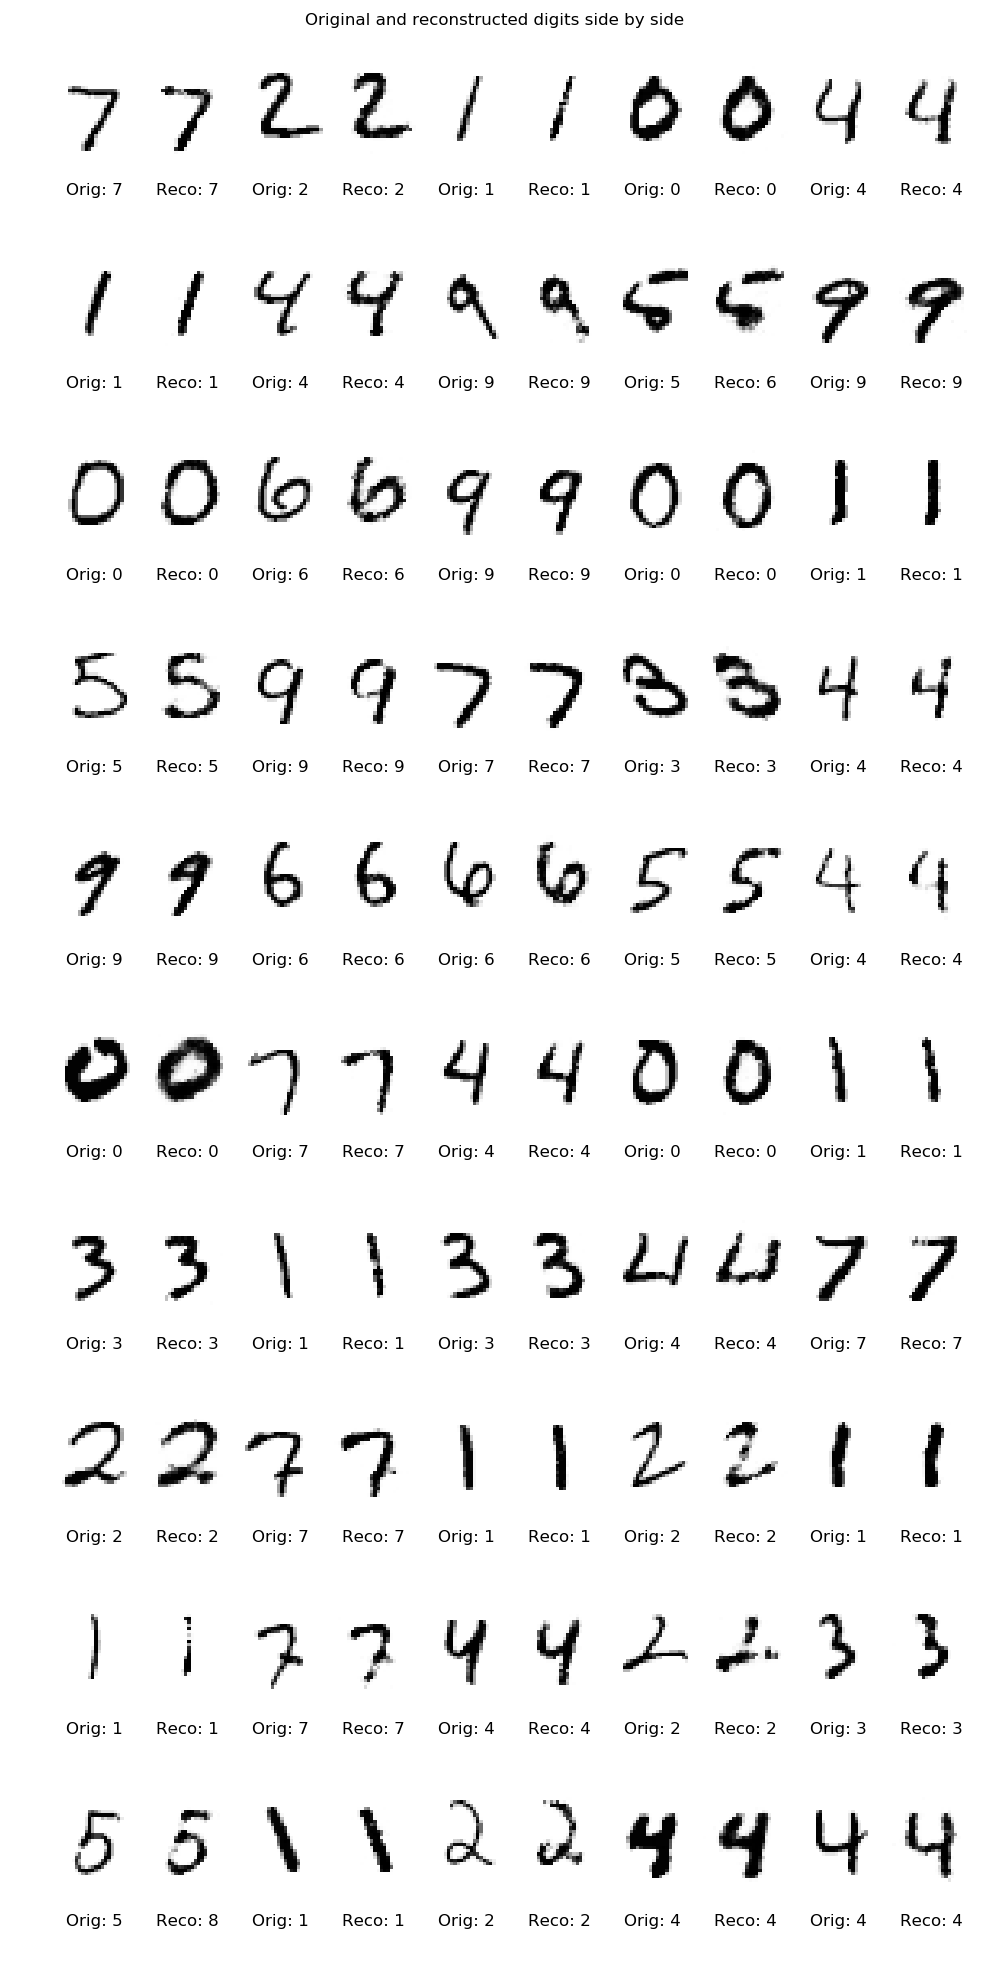

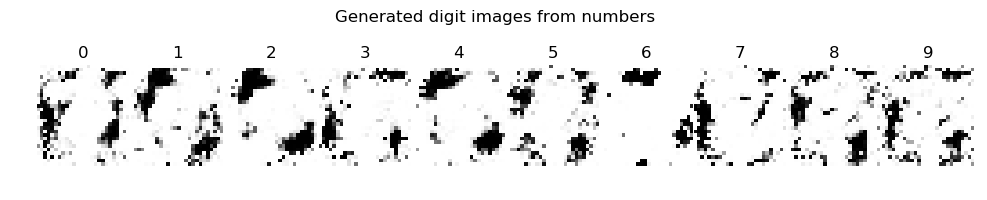

In [3]:

rbm = None
if __name__ == "__main__" and '__file__' not in globals():
    np.seterr(all='raise')
    rbm = MNIST_RBM()
    rbm.train()
    plt.close('all')
    rbm.classify()
    rbm.generate()
    